# Analysis for the the one with curriculum learning

In [1]:
import tbparse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# For the training

In [36]:
from tbparse import SummaryReader
Gen_ARL_train = r"../../TrainerConfig/results/Curr42d/Generator/"
Solver_ARL_train = r"../../TrainerConfig/results/Curr42d/Solver/"
reader_gen = SummaryReader(Gen_ARL_train)
reader_solver = SummaryReader(Solver_ARL_train)
df_solver = reader_solver.scalars
df_gen = reader_gen.scalars
pd.unique(df_gen["tag"])
# df_gen.head()
# df_gen

,step,tag,value
0,1000,Environment/Cumulative Reward,1.182363
1,2000,Environment/Cumulative Reward,1.892153
2,3000,Environment/Cumulative Reward,3.627184
3,4000,Environment/Cumulative Reward,4.152931
4,5000,Environment/Cumulative Reward,5.583900
...,...,...,...
5742,366000,theta,-0.038249
5743,367000,theta,0.992048
5744,368000,theta,1.707731
5745,369000,theta,-0.894614


In [35]:
df_gen

,step,tag,value
0,1000,Environment/Cumulative Reward,1.182363
1,2000,Environment/Cumulative Reward,1.892153
2,3000,Environment/Cumulative Reward,3.627184
3,4000,Environment/Cumulative Reward,4.152931
4,5000,Environment/Cumulative Reward,5.583900
...,...,...,...
5742,366000,theta,-0.038249
5743,367000,theta,0.992048
5744,368000,theta,1.707731
5745,369000,theta,-0.894614


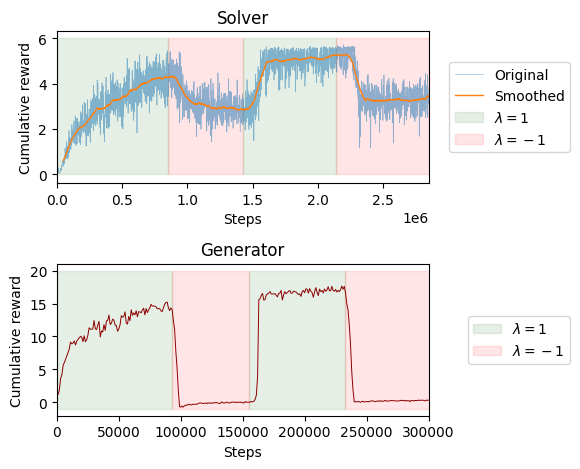

In [135]:
auxs = [0, .3, .5, .75, 1]
solver_cum_pd = df_solver.loc[df_solver["tag"]=="Environment/Cumulative Reward", ["step", "value"]]
ax1 = plt.subplot(2,1,1)

maxstep = 2.85e6
#  Generator
kwards = {'x':"step", 'y':"value", "kind":"line"}
solver_cum_pd.plot(**kwards, linewidth=.5, ax=ax1, alpha=.5, label="Original")
#  Smoothed version
solver_cum_pd.rolling(100).mean().plot(**kwards, linewidth=1, ax=ax1, label="Smoothed")
ax1.set_xlabel("Steps")
ax1.set_ylabel("Cumulative reward")
ax1.set_xlim(0, maxstep)
ax1.set_title("Solver")
fill_args = {'alpha':0.1}
ymax = 6
# Regions
ax1.fill_betweenx([0,ymax],auxs[0]*maxstep,auxs[1]*maxstep, color='darkgreen', **fill_args,
                  label=r"$\lambda=1$")
ax1.fill_betweenx([0,ymax],auxs[1]*maxstep,auxs[2]*maxstep, color='red', **fill_args,
                  label=r"$\lambda=-1$")
ax1.fill_betweenx([0,ymax],auxs[2]*maxstep,auxs[3]*maxstep, color='darkgreen', **fill_args)
ax1.fill_betweenx([0,ymax],auxs[3]*maxstep,auxs[4]*maxstep, color='red', **fill_args)
ax1.legend(loc='center right',bbox_to_anchor=(1.4,.5))

# Solver
maxstep = 3.1e5
ymax=20
ymin=-1
# Solver
ax2 = plt.subplot(2,1,2)
gen_cum_pd = df_gen.loc[df_gen["tag"]=="Environment/Cumulative Reward", ["step", "value"]]
gen_cum_pd.plot(**kwards, ax=ax2, color='darkred', linewidth=.7, label="")
ax2.set_xlabel("Steps")
ax2.set_ylabel("Cumulative reward")
ax2.set_xlim(0, 3e5)
# ax2.legend("", frameon=False)
ax2.set_title("Generator")
# Regions
ax2.fill_betweenx([ymin,ymax],auxs[0]*maxstep,auxs[1]*maxstep, color='darkgreen', **fill_args,
                  label=r"$\lambda=1$")
ax2.fill_betweenx([ymin,ymax],auxs[1]*maxstep,auxs[2]*maxstep, color='red', **fill_args,
                  label=r"$\lambda=-1$")
ax2.fill_betweenx([ymin,ymax],auxs[2]*maxstep,auxs[3]*maxstep, color='darkgreen', **fill_args)
ax2.fill_betweenx([ymin,ymax],auxs[3]*maxstep,auxs[4]*maxstep, color='red', **fill_args)
ax2.legend(loc='center right',bbox_to_anchor=(1.4,.5))
plt.tight_layout()
plt.savefig("images/Cumm_reward_Curr42d.pdf")

# For test

In [253]:
from tbparse import SummaryReader
Gen_ARLPCG = r"../../TrainerConfig/results/InferCurr24/Generator/"
Solver_ARLPCG = r"../../TrainerConfig/results/InferCurr24/Solver/"
reader_gen = SummaryReader(Gen_ARLPCG)
reader_solver = SummaryReader(Solver_ARLPCG)
df = reader_solver.scalars
pd.unique(df["tag"])
df.head()

,step,tag,value
0,40,Environment/Cumulative Reward,-0.446700
1,80,Environment/Cumulative Reward,-0.685800
2,1040,Environment/Cumulative Reward,2.036350
3,1120,Environment/Cumulative Reward,2.035150
4,1160,Environment/Cumulative Reward,2.037225


Succes ratio : 0.7189179286761114


In [272]:
s.describe()

,step,value
count,1.637600e+04,16376.000000
mean,5.328553e+05,5.705279
std,3.008745e+05,1.518563
min,4.000000e+01,1.000000
25%,2.722300e+05,4.818182
50%,5.386600e+05,5.550000
75%,7.919300e+05,6.500000
max,1.050800e+06,10.000000


In [ ]:
def part(key, minim, maxim, data):
    data.loc[]

In [169]:
parts = [0, .2, 0.4, .55, .7, .85, 1]
max_steps = 1e6

thetas_df = df.loc[df["tag"]=="theta", ["step", "value"]]
thetas_df["difficulty"] = 2
thetas_df.loc[thetas_df["step"]<=max_steps*parts[-2], "difficulty"] = -2
thetas_df.loc[thetas_df["step"]<=max_steps*parts[-3], "difficulty"] = .5
thetas_df.loc[thetas_df["step"]<=max_steps*parts[-4], "difficulty"] = -.5
thetas_df.loc[thetas_df["step"]<=max_steps*parts[-5], "difficulty"] = 1
thetas_df.loc[thetas_df["step"]<=max_steps*parts[-6], "difficulty"] = -1

thetas_df.describe()

,step,value,difficulty
count,1000.000000,1000.000000,1000.000000
mean,500500.000000,-0.012846,0.000000
std,288819.436096,0.080404,1.294866
min,1000.000000,-0.369868,-2.000000
25%,250750.000000,-0.054741,-1.000000
50%,500500.000000,-0.012106,0.000000
75%,750250.000000,0.036558,1.000000
max,1000000.000000,0.173074,2.000000


In [233]:
descr = dict()
descr[-2] = thetas_df.loc[thetas_df["difficulty"]==-2,
                          ["value"]].describe().loc[["mean", "std", "min", "max"]]
descr[-1] = thetas_df.loc[thetas_df["difficulty"]==-1,
                          ["value"]].describe().loc[["mean", "std", "min", "max"]]
descr[-0.5] = thetas_df.loc[thetas_df["difficulty"]==-0.5,
                            ["value"]].describe().loc[["mean", "std", "min", "max"]]
# means[0] = thetas_df.loc[thetas_df["difficulty"]==0, ["value"]].mean()
descr[0.5] = thetas_df.loc[thetas_df["difficulty"]==0.5,
                           ["value"]].describe().loc[["mean", "std", "min", "max"]]
descr[1] = thetas_df.loc[thetas_df["difficulty"]==1,
                         ["value"]].describe().loc[["mean", "std", "min", "max"]]
descr[2] = thetas_df.loc[thetas_df["difficulty"]==2,
                         ["value"]].describe().loc[["mean", "std", "min", "max"]]

theta_final = pd.DataFrame()
# rename the columns
for key in list(descr.keys()):
    descr[key] = descr[key].rename(columns={"value":key})
    theta_final[key] = descr[key]
# Print
print("theta : according to the aux. input")
# pd.DataFrame(means) * 180/np.pi # Conversion to degree
theta_final

theta : according to the aux. input


,-2.0,-1.0,-0.5,0.5,1.0,2.0
mean,0.044244,-0.033551,-0.137795,-0.015088,-0.014338,0.086850
std,0.053717,0.045717,0.070410,0.032324,0.034057,0.022979
min,-0.066431,-0.135039,-0.369868,-0.095325,-0.098113,0.018075
max,0.173074,0.107482,0.004919,0.079313,0.064833,0.163380


In [356]:
sd = thetas_df.loc[thetas_df["difficulty"]==-2,
                          ["value"]]

sd = sd.reset_index().loc[:, "value":] # get rid of indices
sd

,value
0,0.058539
1,0.006183
2,-0.050215
3,0.018309
4,0.133529
...,...
2584,-0.209049
2585,0.217976
2586,0.222290
2587,0.167057


In [360]:
# To describe a tag in the event data
def describe_tag(tag="tag", tag_df=pd.DataFrame()):
    parts = [0, .2, 0.4, .55, .7, .85, 1]
    max_steps = 1e6

    tag_df["difficulty"] = 2
    tag_df.loc[tag_df["step"]<=max_steps*parts[-2], "difficulty"] = -2
    tag_df.loc[tag_df["step"]<=max_steps*parts[-3], "difficulty"] = .5
    tag_df.loc[tag_df["step"]<=max_steps*parts[-4], "difficulty"] = -.5
    tag_df.loc[tag_df["step"]<=max_steps*parts[-5], "difficulty"] = 1
    tag_df.loc[tag_df["step"]<=max_steps*parts[-6], "difficulty"] = -1
    
    descr = dict()
    descr[-2] = tag_df.loc[tag_df["difficulty"]==-2, ["value"]]
    descr[-1] = tag_df.loc[tag_df["difficulty"]==-1, ["value"]]
    descr[-0.5] = tag_df.loc[tag_df["difficulty"]==-0.5, ["value"]] 
    descr[0.5] = tag_df.loc[tag_df["difficulty"]==0.5, ["value"]]
    descr[1] = tag_df.loc[tag_df["difficulty"]==1, ["value"]] 
    descr[2] = tag_df.loc[tag_df["difficulty"]==2, ["value"]] 

    tag_final = pd.DataFrame()
    # rename the columns
    for key in list(descr.keys()):
        descr[key] = descr[key].rename(columns={"value":key})
        tag_final[key] = descr[key].reset_index().loc[:, key:] # get rid of indices
    # Print
    print(f"{tag} : according to the aux. input")
    return tag_final

In [361]:
thetas_df = df.loc[df["tag"]=="theta", ["step", "value"]]
res = describe_tag("theta", thetas_df)
# res.loc["mean":"max"] = res.loc["mean":"max"] * 180/np.pi # Conversion to degree
res

theta : according to the aux. input


,-2.0,-1.0,-0.5,0.5,1.0,2.0
0,0.058539,0.073646,0.433011,0.297053,0.268454,0.088329
1,0.006183,0.080538,0.043103,0.094207,0.536705,-0.064928
2,-0.050215,0.057932,0.097788,0.285839,-0.080300,0.072725
3,0.018309,0.002098,0.026749,0.391938,0.109442,0.062542
4,0.133529,0.285248,0.148260,0.003516,0.238050,-0.030155
...,...,...,...,...,...,...
2584,-0.209049,0.150700,NaN,NaN,-0.118246,-0.302787
2585,0.217976,0.179053,NaN,NaN,-0.003879,-0.044055
2586,0.222290,-0.337589,NaN,NaN,0.196986,-0.371623
2587,0.167057,0.441647,NaN,NaN,0.252645,-0.222949


In [362]:
distance_df = df.loc[df["tag"]=="distance", ["step", "value"]]
describe_tag("distance", distance_df)

distance : according to the aux. input


,-2.0,-1.0,-0.5,0.5,1.0,2.0
0,3.072249,2.274951,2.764331,2.842764,2.554357,1.588080
1,2.570352,2.348693,2.814887,2.701173,2.348186,2.025913
2,2.883218,2.300599,2.898962,1.747223,2.341232,1.803083
3,2.669661,2.271311,2.789864,2.484716,2.501151,2.640048
4,1.767251,2.700643,2.190789,2.643192,2.360909,1.672316
...,...,...,...,...,...,...
2584,1.484342,2.558991,NaN,NaN,3.020042,3.665733
2585,1.577523,2.158498,NaN,NaN,2.945064,3.108217
2586,1.766029,2.393460,NaN,NaN,2.857247,3.134047
2587,2.097621,1.842728,NaN,NaN,2.697944,3.118926


In [294]:
height_df = df.loc[df["tag"]=="height", ["step", "value"]]
describe_tag("height", height_df)

height : according to the aux. input


,-2.0,-1.0,-0.5,0.5,1.0,2.0
count,2589.000000,2963.000000,2315.000000,2336.000000,3082.000000,3114.000000
mean,4.730278,4.858551,4.902638,4.922013,4.911676,4.836259
std,0.253601,0.297533,0.312395,0.340362,0.349355,0.353536
min,3.722886,3.111685,3.115392,3.076906,2.659525,3.080980
max,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000


In [414]:
Score_df = df.loc[df["tag"]=="Score", ["step", "value"]]
describe_tag("Score", Score_df).describe()

Score : according to the aux. input


,-2.0,-1.0,-0.5,0.5,1.0,2.0
count,2586.000000,2586.000000,2311.000000,2338.000000,2586.000000,2586.000000
mean,5.825744,5.673252,5.612183,5.684234,5.717542,5.717648
std,1.270006,1.459232,1.459358,1.588001,1.634601,1.650034
min,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,5.000000,4.857143,4.800000,4.743951,4.750000,4.714286
50%,5.642857,5.545455,5.500000,5.500000,5.500000,5.500000
75%,6.440476,6.454545,6.333333,6.500000,6.500000,6.500000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [418]:
Score_df = df.loc[df["tag"]=="Score", ["step", "value"]]
# print(describe_tag("Score", Score_df))
def success_ratio(Score_df, aux_input=1.0, threshold=5):
    s1 = describe_tag("Score", Score_df)
    s1 = s1.loc[:,[aux_input]]
    success = s1[s1[aux_input]>threshold].describe().iloc[0,0]
    total = s1.describe().iloc[0,0]
    print(success, total)
    return success/total
print(f"Success ratio : {success_ratio(Score_df, -2.0, 5)}")

Score : according to the aux. input
1893.0 2586.0
Success ratio : 0.7320185614849188


In [248]:
pd.unique(df["tag"])

array(['Environment/Cumulative Reward', 'Environment/Episode Length',
       'Environment/Lesson Number/aux_input',
       'Environment/Lesson Number/n_obstacles', 'Losses/Policy Loss',
       'Losses/Value Loss', 'Policy/Beta', 'Policy/Entropy',
       'Policy/Epsilon', 'Policy/Extrinsic Reward',
       'Policy/Extrinsic Value Estimate', 'Policy/Learning Rate', 'Score',
       'distance', 'height', 'theta'], dtype=object)